In [1]:
import h5py
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
mask = np.load(r"C:\Users\DU\aman_fastmri\Data\mask_4x_320_random.npy")  # Shape: (1, 320, 320)
print("og shape:", mask.shape)

# # Use np.tile to reshape it to (1, 320, 320, 1)
# # var_sampling_mask = np.tile(var_sampling_mask[..., np.newaxis], (1, 1, 1, 1))  # Final shape: (1, 320, 320, 1)
# mask = np.tile(mask, (1, 320, 1, 2))  # tile height=320 times

# # Confirm final shape
# print("New shape:", mask.shape) 
# mask_for_plot = np.squeeze(mask[...,0])  # Shape: (320, 320)

# # Plot
# plt.figure(figsize=(5, 5))
# plt.imshow(mask_for_plot, cmap='gray')
# plt.title("Tiled Sampling Mask (320x320)")
# plt.axis('off')
# plt.show()

og shape: (1, 1, 320, 1)


In [3]:
import h5py
import numpy as np
import tensorflow as tf

class MRISliceGenerator(tf.keras.utils.Sequence):
    def __init__(self, file_list, batch_size=4, shuffle=True, mask=None):
        self.file_list = file_list
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.mask = mask  # Shape: (1, 320, 320, 2)
        self.slice_index_map = []
        self._build_index()

    def _build_index(self):
        for file_idx, file_path in enumerate(self.file_list):
            with h5py.File(file_path, 'r') as f:
                num_slices = f['image_under'].shape[0]
                for slice_idx in range(num_slices):
                    self.slice_index_map.append((file_idx, slice_idx))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.slice_index_map) / self.batch_size))

    def __getitem__(self, index):
        batch_map = self.slice_index_map[index * self.batch_size:(index + 1) * self.batch_size]

        input_img_batch = []
        target_img_batch = []
        input_kspace_batch = []

        for file_idx, slice_idx in batch_map:
            with h5py.File(self.file_list[file_idx], 'r') as f:
                #input_img = f['image_under'][slice_idx]       # shape: [H, W, 2]
                target_img = f['image_full'][slice_idx]       # shape: [H, W, 2]
                input_kspace = f['kspace_under'][slice_idx]   # shape: [H, W, 2]

                #input_img_batch.append(input_img)
                target_img_batch.append(target_img)
                input_kspace_batch.append(input_kspace)

        #x_img = np.stack(input_img_batch, axis=0)
        x_kspace = np.stack(input_kspace_batch, axis=0)
        y_batch = np.stack(target_img_batch, axis=0)

        if self.mask is not None:
            actual_batch_size = len(x_kspace)

            # mask must be (1, 1, W, 1)
            if self.mask.shape != (1, 1, 320, 1):
                raise ValueError("Mask must have shape (1, 1, W, 1)")
        
            # Tile ONLY along batch dimension
            mask_batch = np.tile(self.mask, (actual_batch_size, 1, 1, 1))
        
        return [x_kspace, mask_batch], y_batch

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.slice_index_map)


In [4]:
train_folder = r"D:\fastmri_singlecoil_FSSCAN\train_sub_norm"
val_folder = r"D:\fastmri_singlecoil_FSSCAN\val_norm"

In [5]:
import h5py
import numpy as np
import glob
import os
kspace_files_list_train = sorted(glob.glob(os.path.join(train_folder, "*.h5")))
kspace_files_list_val = sorted(glob.glob(os.path.join(val_folder, "*.h5")))

# half_train = 20
# half_val = 10
half_train = len(kspace_files_list_train) 
half_val = len(kspace_files_list_val) 
# print("half_train",half_train)
# print("half_val",half_val)
kspace_files_list_train = kspace_files_list_train[:half_train]
kspace_files_list_val = kspace_files_list_val[:half_val]

# Create generators
train_gen = MRISliceGenerator(kspace_files_list_train,batch_size=4, shuffle=True,mask=mask)
val_gen = MRISliceGenerator(kspace_files_list_val, batch_size=4, shuffle=False,mask=mask)
# train_gen = MRISliceGenerator(kspace_files_list_train,batch_size=16, shuffle=True)
# val_gen = MRISliceGenerator(kspace_files_list_val, batch_size=4, shuffle=False)

print(len(train_gen))  
print(len(val_gen))  


2171
1784


In [4]:
%run ./TEID_Net.ipynb


Model: "CascadedTEIDNet_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 kspace_undersampled (InputLaye  [(None, 320, 320, 2  0          []                               
 r)                             )]                                                                
                                                                                                  
 sampling_mask (InputLayer)     [(None, 1, 320, 1)]  0           []                               
                                                                                                  
 cascaded_teid_net (CascadedTEI  (None, 320, 320, 2)  2521475    ['kspace_undersampled[0][0]',    
 DNet)                                                            'sampling_mask[0][0]']          
                                                                              

In [ ]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# ============================================================
# Directory Setup
# ============================================================
save_dir = "./SavedModels_TEID_Net_lr"
os.makedirs(save_dir, exist_ok=True)

# ============================================================
# Configuration
# ============================================================
H, W = 320, 320
EPOCHS = 50
LEARNING_RATE = 1e-4

# TensorFlow checkpoint paths (NO .h5)
INIT_CKPT  = os.path.join(save_dir, "init_ckpt")
BEST_CKPT  = os.path.join(save_dir, "best_ckpt")
FINAL_CKPT = os.path.join(save_dir, "final_ckpt")

print("=" * 60)
print("🔧 TRAINING CONFIGURATION")
print("=" * 60)
print(f" Save Directory:       {save_dir}")
print(f" Model Dimensions:     {H}x{W}")
print(f" Epochs:               {EPOCHS}")
print(f" Learning Rate:        {LEARNING_RATE}")
print(f" Init Checkpoint:      {INIT_CKPT}")
print(f" Best Checkpoint:      {BEST_CKPT}")
print(f" Final Checkpoint:     {FINAL_CKPT}")
print("=" * 60)

# ============================================================
# Model Setup
# ============================================================
model = build_cascaded_teid_model(
    H=H,
    W=W,
    num_cascades=5,
    channels=64
)

# ============================================================
# Optimizer & Compile
# ============================================================
optimizer = Adam(learning_rate=LEARNING_RATE)
model.compile(optimizer=optimizer, loss="mae")

# ============================================================
# Load Initial Weights (Optional Resume)
# ============================================================
if tf.train.latest_checkpoint(save_dir):
    model.load_weights(tf.train.latest_checkpoint(save_dir))
    print("✅ Loaded latest checkpoint")
else:
    print("ℹ️ No checkpoint found. Training from scratch.")

# ============================================================
# Callbacks
# ============================================================
checkpoint_cb = ModelCheckpoint(
    filepath=BEST_CKPT,
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

earlystop_cb = EarlyStopping(
    monitor="val_loss",
    patience=20,
    restore_best_weights=True,
    verbose=1
)

reduce_lr_cb = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=10,
    min_lr=1e-7,
    verbose=1
)

callbacks = [checkpoint_cb, earlystop_cb, reduce_lr_cb]

# ============================================================
# Training
# ============================================================
print("\n🚀 STARTING TRAINING...")
print("=" * 60)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

print("\n✅ TRAINING COMPLETED")

# ============================================================
# Save Final Weights
# ============================================================
model.save_weights(FINAL_CKPT)
print(f"✅ Final weights saved to {FINAL_CKPT}")

# ============================================================
# Training Analysis
# ============================================================
if history:
    print("\n📊 TRAINING ANALYSIS")
    print("=" * 60)
    best_epoch = np.argmin(history.history["val_loss"]) + 1
    print(f" Best Epoch: {best_epoch}")
    print(f" Best Val Loss: {np.min(history.history['val_loss']):.6f}")

# ============================================================
# Plot Training Curves
# ============================================================

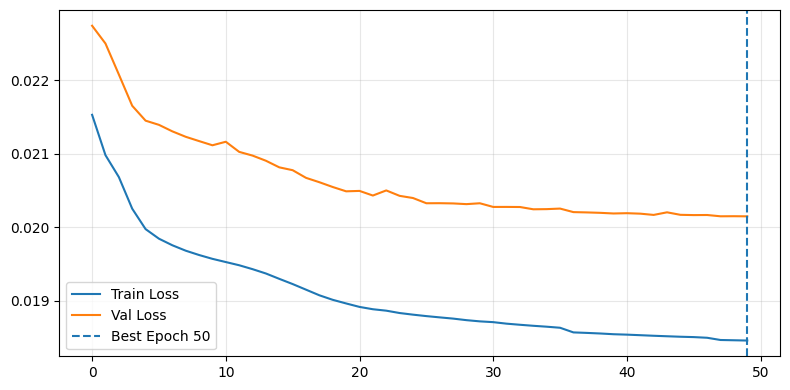

<Figure size 640x480 with 0 Axes>

In [10]:
def plot_training_history(hist):
    plt.figure(figsize=(8, 4))
    plt.plot(hist["loss"], label="Train Loss")
    plt.plot(hist["val_loss"], label="Val Loss")
    best_ep = int(np.argmin(hist["val_loss"]))
    plt.axvline(best_ep, linestyle="--", label=f"Best Epoch {best_ep+1}")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    plt.savefig("TEID_Net_curve.png")

if history:
    plot_training_history(history.history)

🔧 TRAINING CONFIGURATION
 Save Directory:       ./SavedModels_TEID_Net_lr
 Model Dimensions:     320x320
 Epochs:               50
 Learning Rate:        0.0001
 Init Checkpoint:      ./SavedModels_TEID_Net_lr\init_ckpt
 Best Checkpoint:      ./SavedModels_TEID_Net_lr\best_ckpt
 Final Checkpoint:     ./SavedModels_TEID_Net_lr\final_ckpt
ℹ️ No checkpoint found. Training from scratch.

🚀 STARTING TRAINING...
Epoch 1/50
2171/2171 [==============================] - ETA: 0s - loss: 0.0215      
Epoch 1: val_loss improved from inf to 0.02274, saving model to ./SavedModels_TEID_Net_lr\best_ckpt
2171/2171 [==============================] - 4286s 2s/step - loss: 0.0215 - val_loss: 0.0227 - lr: 1.0000e-04
Epoch 2/50
2171/2171 [==============================] - ETA: 0s - loss: 0.0210   
Epoch 2: val_loss improved from 0.02274 to 0.02250, saving model to ./SavedModels_TEID_Net_lr\best_ckpt
2171/2171 [==============================] - 4225s 2s/step - loss: 0.0210 - val_loss: 0.0225 - lr: 1.0000e-04

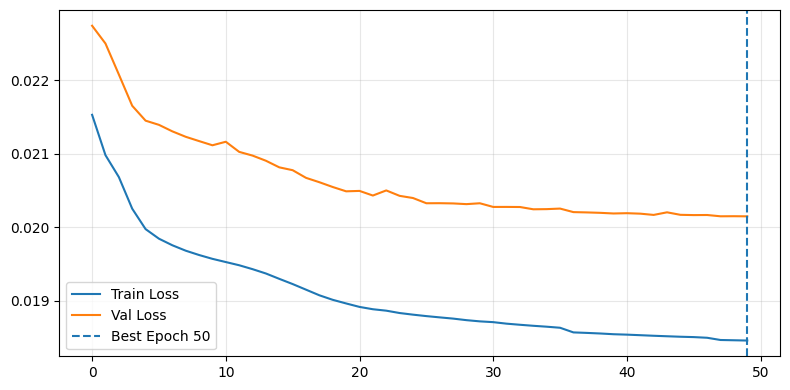

In [ ]:
import os
import numpy as np
import h5py
import glob
from tqdm import tqdm
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

# # Path to validation folder
# # val_folder = "F:/denoised_preprocessed_h5_val"

# val_folder = r"E:\fastmri\val_norm"
# # val_folder = r"D:\val_norm"

# # val_folder = r"G:\val_norm\val_norm"
# # files = sorted([os.path.join(val_folder, f) for f in os.listdir(val_folder) if f.endswith(".h5")])
# kspace_files_list_val = sorted(glob.glob(os.path.join(val_folder, "*.h5")))
file_paths = kspace_files_list_val


# ----------------------
# HELPERS
# ----------------------
def to_complex(x):
    return x[..., 0] + 1j * x[..., 1]

def nmse(gt, pred):
    return np.linalg.norm(gt - pred) ** 2 / (np.linalg.norm(gt) ** 2 + 1e-10)

def compute_ssim(gt, pred, max_val):
    return structural_similarity(
        gt, pred,
        data_range=max_val,
        win_size=9,
        gaussian_weights=False,
        use_sample_covariance=False,
        K1=0.01,
        K2=0.03
    )

# ----------------------
# STORAGE
# ----------------------
ssim_list = []
psnr_list = []
nmse_list = []

# ----------------------
# PROCESSING
# ----------------------
for file in tqdm(file_paths, desc="Processing volumes"):
    with h5py.File(file, 'r') as f:
        image_full = f["image_full"][:]       # (slices, H, W, 2)
        image_under = f["image_under"][:]     # (slices, H, W, 2)
        max_val = float(f["max_val_full_image"][0])

#     mask_batch = np.tile(mask, (image_under.shape[0], 1, 1, 1)) 
    # Get model prediction (still in normalized form)
    # pred = model.predict([image_under,mask_batch,image_under], verbose=0)  # shape (slices, H, W, 2)
    pred = model.predict(image_under, verbose=0)  # shape (slices, H, W, 2)
    
    image_full *= max_val
    
    pred *= max_val  # Scale predicted output to original intensity range

    # Convert to complex and get magnitude
    gt_mag = np.abs(to_complex(image_full))
    pred_mag = np.abs(to_complex(pred))

    # Volume-wise PSNR and NMSE
    psnr_val = peak_signal_noise_ratio(gt_mag, pred_mag, data_range=max_val)
    nmse_val = nmse(gt_mag.flatten(), pred_mag.flatten())

    psnr_list.append(psnr_val)
    nmse_list.append(nmse_val)

    # Slice-wise SSIM
    for i in range(gt_mag.shape[0]):
        ssim_val = compute_ssim(gt_mag[i], pred_mag[i], max_val)
        ssim_list.append(ssim_val)

# ----------------------
# REPORT
# ----------------------
print("\n" + "=" * 40)
print(f"PSNR (Mag, volume): {np.mean(psnr_list):.2f} ± {np.std(psnr_list):.2f} dB")
print(f"NMSE (Mag, volume): {np.mean(nmse_list):.6f} ± {np.std(nmse_list):.6f}")
print(f"SSIM (Mag, slice):  {np.mean(ssim_list):.4f} ± {np.std(ssim_list):.4f}")

print("=" * 40)


In [5]:
import tensorflow as tf
import os
import glob
import h5py
import numpy as np
from tqdm import tqdm
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

# ----------------------
# PATHS
# ----------------------
#VAL_FOLDER = r"E:\fastmri\val_norm"
CKPT_DIR   = "./SavedModels_TEID_Net_lr"
BEST_CKPT  = os.path.join(CKPT_DIR, "best_ckpt")

#file_paths = sorted(glob.glob(os.path.join(VAL_FOLDER, "*.h5")))

# ----------------------
# MODEL REBUILD
# ----------------------

val_folder = r"D:\fastmri_singlecoil_FSSCAN\val_sub_norm"
import h5py
import numpy as np
import glob
import os
#kspace_files_list_train = sorted(glob.glob(os.path.join(train_folder, "*.h5")))
kspace_files_list_val = sorted(glob.glob(os.path.join(val_folder, "*.h5")))

# half_train = 20
# half_val = 10
#half_train = len(kspace_files_list_train) 
half_val = len(kspace_files_list_val) 
# print("half_train",half_train)
# print("half_val",half_val)
#kspace_files_list_train = kspace_files_list_train[:half_train]
kspace_files_list_val = kspace_files_list_val[:half_val]

# Create generators
#train_gen = MRISliceGenerator(kspace_files_list_train,batch_size=4, shuffle=True,mask=mask)
val_gen = MRISliceGenerator(kspace_files_list_val, batch_size=4, shuffle=False,mask=mask)
# train_gen = MRISliceGenerator(kspace_files_list_train,batch_size=16, shuffle=True)
# val_gen = MRISliceGenerator(kspace_files_list_val, batch_size=4, shuffle=False)

#print(len(train_gen))  
print(len(val_gen))  

H, W = 320, 320

model = build_cascaded_teid_model(
    H=H,
    W=W,
    num_cascades=5,
    channels=64
)

# Compile is optional for inference, but safe
model.compile(optimizer="adam", loss="mae")
model.load_weights(BEST_CKPT)
print(f"✅ Loaded BEST checkpoint: {BEST_CKPT}")
def to_complex(x):
    return x[..., 0] + 1j * x[..., 1]

def nmse(gt, pred):
    return np.linalg.norm(gt - pred) ** 2 / (np.linalg.norm(gt) ** 2 )

def compute_ssim(gt, pred, max_val):
    return structural_similarity(
        gt, pred,
        data_range=max_val,
        win_size=7,
        gaussian_weights=False,
        use_sample_covariance=False,
        K1=0.01,
        K2=0.03,
        full=False
    )
# ----------------------
# STORAGE
psnr_list = []
nmse_list = []
ssim_list = []

for file in tqdm(kspace_files_list_val, desc="Processing volumes"):
    with h5py.File(file, 'r') as f:
        kspace_under = f["kspace_under"][:]   # (S, H, W, 2)
        image_full   = f["image_full"][:]     # (S, H, W, 2)
        max_val = float(f["max_val_full_image"][0])

    num_slices = kspace_under.shape[0]

    # --------------------------------------------------
    # TILE MASK FOR THIS VOLUME
    # --------------------------------------------------
    mask_batch = np.tile(mask, (num_slices, 1, 1, 1))

    # --------------------------------------------------
    # MODEL INFERENCE
    # --------------------------------------------------
    pred = model.predict(
        [kspace_under, mask_batch],
        batch_size=1,
        verbose=0
    )

    # --------------------------------------------------
    # DE-NORMALIZE
    # --------------------------------------------------
    image_full = image_full * max_val
    pred = pred * max_val

    # --------------------------------------------------
    # MAGNITUDE
    # --------------------------------------------------
    gt_mag   = np.abs(to_complex(image_full))
    pred_mag = np.abs(to_complex(pred))

    # --------------------------------------------------
    # VOLUME METRICS
    # --------------------------------------------------
    psnr_list.append(
        peak_signal_noise_ratio(gt_mag, pred_mag, data_range=max_val)
    )

    nmse_list.append(
        nmse(gt_mag.flatten(), pred_mag.flatten())
    )

    # --------------------------------------------------
    # SLICE METRICS
    # --------------------------------------------------
    for i in range(gt_mag.shape[0]):
        ssim_list.append(
            compute_ssim(gt_mag[i], pred_mag[i], max_val)
        )
print("\n" + "=" * 50)
print(f"PSNR (Mag, volume): {np.mean(psnr_list):.2f} ± {np.std(psnr_list):.2f} dB")
print(f"NMSE (Mag, volume): {np.mean(nmse_list):.6f} ± {np.std(nmse_list):.6f}")
print(f"SSIM (Mag, slice):  {np.mean(ssim_list):.4f} ± {np.std(ssim_list):.4f}")
print("=" * 50)


438
✅ Loaded BEST checkpoint: ./SavedModels_TEID_Net_lr\best_ckpt


Processing volumes: 100%|██████████████████████████████████████████████████████████████| 50/50 [05:46<00:00,  6.93s/it]


PSNR (Mag, volume): 32.18 ± 2.21 dB
NMSE (Mag, volume): 0.026475 ± 0.014080
SSIM (Mag, slice):  0.7505 ± 0.0728
